In [3]:
import os
import re

from h5py import File
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pyproj

mpl.rcParams['figure.dpi'] = 100

In [4]:
# filepath = S3Path(omi_md.iloc[0].us_url)
filepath = r'G:\OMI-Aura_L3-OMNO2d_2004m1001_v003-2019m1121t082956.he5'

In [6]:
hdf = File(filepath, mode="r")

# List available datasets
for k, v in hdf.items():
    print(f"{k}: {v}")

HDFEOS: <HDF5 group "/HDFEOS" (2 members)>
HDFEOS INFORMATION: <HDF5 group "/HDFEOS INFORMATION" (1 members)>


In [7]:
def print_structure(name, obj):
    print(name)

hdf.visititems(print_structure)

HDFEOS
HDFEOS/ADDITIONAL
HDFEOS/ADDITIONAL/FILE_ATTRIBUTES
HDFEOS/GRIDS
HDFEOS/GRIDS/ColumnAmountNO2
HDFEOS/GRIDS/ColumnAmountNO2/Data Fields
HDFEOS/GRIDS/ColumnAmountNO2/Data Fields/ColumnAmountNO2
HDFEOS/GRIDS/ColumnAmountNO2/Data Fields/ColumnAmountNO2CloudScreened
HDFEOS/GRIDS/ColumnAmountNO2/Data Fields/ColumnAmountNO2Trop
HDFEOS/GRIDS/ColumnAmountNO2/Data Fields/ColumnAmountNO2TropCloudScreened
HDFEOS/GRIDS/ColumnAmountNO2/Data Fields/Weight
HDFEOS INFORMATION
HDFEOS INFORMATION/StructMetadata.0


In [8]:
trop_NO2 = hdf["HDFEOS"]["GRIDS"]["ColumnAmountNO2"]["Data Fields"]["ColumnAmountNO2Trop"]
raw_NO2 = trop_NO2[:]
raw_NO2

array([[-1.2676506e+30, -1.2676506e+30, -1.2676506e+30, ...,
        -1.2676506e+30, -1.2676506e+30, -1.2676506e+30],
       [-1.2676506e+30, -1.2676506e+30, -1.2676506e+30, ...,
        -1.2676506e+30, -1.2676506e+30, -1.2676506e+30],
       [-1.2676506e+30, -1.2676506e+30, -1.2676506e+30, ...,
        -1.2676506e+30, -1.2676506e+30, -1.2676506e+30],
       ...,
       [-1.2676506e+30, -1.2676506e+30, -1.2676506e+30, ...,
        -1.2676506e+30, -1.2676506e+30, -1.2676506e+30],
       [-1.2676506e+30, -1.2676506e+30, -1.2676506e+30, ...,
        -1.2676506e+30, -1.2676506e+30, -1.2676506e+30],
       [-1.2676506e+30, -1.2676506e+30, -1.2676506e+30, ...,
        -1.2676506e+30, -1.2676506e+30, -1.2676506e+30]], dtype=float32)

In [9]:
shape = raw_NO2.shape
shape

(720, 1440)

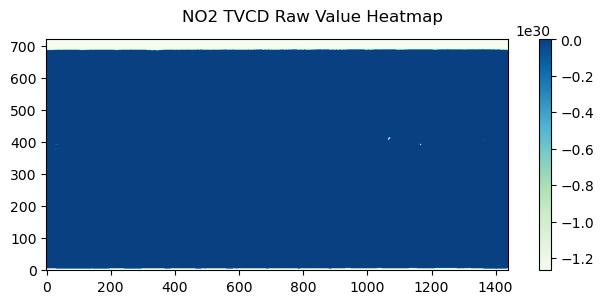

In [10]:
# Plot raw value heatmap
for_plot = raw_NO2.copy() 

f, ax = plt.subplots(1, 1, figsize=(8, 3))
img = plt.imshow(for_plot, origin="lower", cmap="GnBu")
f.colorbar(img)
plt.suptitle("NO2 TVCD Raw Value Heatmap", fontsize=12);

# Calibrating NO2 data

In [11]:
# List available attributes
for k, v in trop_NO2.attrs.items():
    print(f"{k}: {v}")

Description: b'Field=ColumnAmountNO2Trop,StdField=ColumnAmountNO2TropStd,SolarZenithAngle=[0:85],VcdQualityFlags=~19,XTrackQualityFlags=~[1:254],TerrainReflectivity=[0:1000]'
MissingValue: [-1.2676506e+30]
Offset: [0.]
ScaleFactor: [1.]
Title: b'NO2 tropospheric column density'
Units: b'molec/cm2'
_FillValue: [-1.2676506e+30]


In [12]:
# Save attributes to a calibration dictionary
calibration_dict = {
    "scale_factor": trop_NO2.attrs["ScaleFactor"][0],
    "offset": trop_NO2.attrs["Offset"][0],
    "missing_data_value": trop_NO2.attrs["_FillValue"][0]
}
calibration_dict

{'scale_factor': 1.0, 'offset': 0.0, 'missing_data_value': -1.2676506e+30}

In [13]:
def calibrate_data(data: File, calibration_dict: Dict):
    """Given an OMI dataset and calibration parameters, return a masked
    array of calibrated data.
    
    Args:
        data (File): dataset in the File format (e.g. column NO2).
        calibration_dict (Dict): dictionary containing, at a minimum,
            `scale_factor` (float), `offset` (float),
            `missing_data_value` (float).
    
    Returns:
        corrected_NO2 (np.ma.MaskedArray): masked array of calibrated data
            with a fill value of nan.
    """
    # Convert missing data to nan
    data[data == calibration_dict["missing_data_value"]] = np.nan
    
    # Remove negative values
    data[data < 0] = np.nan
    
    # Calibrate using offset and scale factor
    data = (
        (data - calibration_dict["offset"]) *
        calibration_dict["scale_factor"]
    ) / (10 ** 15) # Divide by 10^15 for readability
    
    # Convert to masked array
    data = np.ma.masked_where(np.isnan(data), data)
    data.fill_value = np.nan

    return data

In [14]:
corrected_NO2 = calibrate_data(raw_NO2, calibration_dict)
corrected_NO2

masked_array(
  data=[[--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        ...,
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --]],
  mask=[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],
  fill_value=nan)

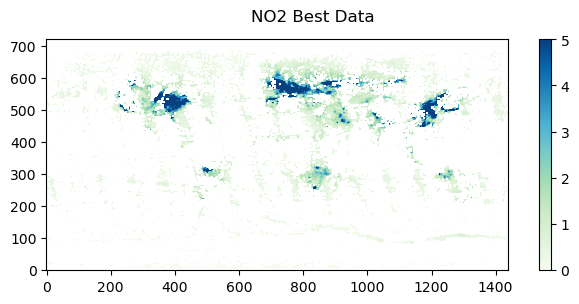

In [17]:
f, ax = plt.subplots(1, 1, figsize=(8, 3))
img = plt.imshow(corrected_NO2, vmin = 0,vmax=5,origin="lower", cmap="GnBu")
f.colorbar(img)
plt.suptitle("NO2 Best Data", fontsize=12);

# Multiple days

In [ ]:
def calibrate_data(data: File, calibration_dict: 'Dict'):
    """Given an OMI dataset and calibration parameters, return a masked
    array of calibrated data.
    
    Args:
        data (File): dataset in the File format (e.g. column NO2).
        calibration_dict (Dict): dictionary containing, at a minimum,
            `scale_factor` (float), `offset` (float),
            `missing_data_value` (float).
    
    Returns:
        corrected_NO2 (np.ma.MaskedArray): masked array of calibrated data
            with a fill value of nan.
    """
    # Convert missing data to nan
    data[data == calibration_dict["missing_data_value"]] = np.nan
    
    # Remove negative values
    data[data < 0] = np.nan
    
    # Calibrate using offset and scale factor
    data = (
        (data - calibration_dict["offset"]) *
        calibration_dict["scale_factor"]
    ) / (10 ** 15) # Divide by 10^15 for readability
    
    # Convert to masked array
    data = np.ma.masked_where(np.isnan(data), data)
    data.fill_value = np.nan

    return data

In [ ]:
days  = []
np_dates = np.arange('2000-03-03', '2016-05-30', dtype='datetime64[D]')
dates01 = np.datetime_as_string(np_dates, unit='D')
for i in np.arange(0,(len(dates01))):
    dates0 = dates01[i][0:4]+'m'+dates01[i][5:7]+dates01[i][8:10]
    days.append(dates0)

In [ ]:
data_f = []
# Save attributes to a calibration dictionary
calibration_dict = {
    "scale_factor": trop_NO2.attrs["ScaleFactor"][0],
    "offset": trop_NO2.attrs["Offset"][0],
    "missing_data_value": trop_NO2.attrs["_FillValue"][0]
}
for k  in days:
    for file in list(glob.glob(r'G:\OMI_Aura_NO2\OMI-Aura_L3-OMNO2d_'+k+'_v003-*.he5')):
        reader = open(file)
#         filepath = r'G:\OMI_Aura_NO2\OMI-Aura_L3-OMNO2d_'+days[i]+'_v003-*.he5'
        hdf = File(file, mode="r")
        trop_NO2 = hdf["HDFEOS/GRIDS/ColumnAmountNO2/Data Fields/ColumnAmountNO2Trop"]
        raw_NO2 = trop_NO2[:]
        raw_NO2
        corrected_NO2 = calibrate_data(raw_NO2, calibration_dict)
        data_f.append(corrected_NO2.data)
    

In [ ]:
import xarray as xr
colamNO2trop_03032006_27092008 = xr.Dataset(
    data_vars={"ColumnAmountNO2Trop": (("time","lat","lon",),np.array(data_f))
              },
    coords = {"lat":(("lat"),np.arange(-90,90,0.25),),
              "lon":(("lon"),np.arange(-180,180,0.25)),
              "time":(("time"),days)},
    
    attrs={'Long_name':'NO2 vertical column density',
           'units':'molec/cm2',
           'title': 'OMI/Aura NO2 Cloud-Screened Total and TroposphericColumn L3 Global Gridded 0.25 degree x 0.25 degree V3(OMNO2d) at GES DISC',
           'dimensions(sizes)': 'lon(1440), lat(720), time(516)',
          })

In [ ]:
del colamNO2trop

In [ ]:
colamNO2trop_03032006_27092008.to_netcdf('colamNO2trop_03032006_27092008.nc4')